In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os

# Assuming your data is extracted in './urban_data' from your previous step
DATA_PATH = '/kaggle/input/datasets/chrisfilo/urbansound8k'
metadata = pd.read_csv(f'{DATA_PATH}/UrbanSound8K.csv')

print(f"Dataset contains {len(metadata)} audio samples.")
metadata.head()

Dataset contains 8732 audio samples.


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


/tmp/ipykernel_17/3994812723.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata, x='class', order=metadata['class'].value_counts().index, palette='viridis')


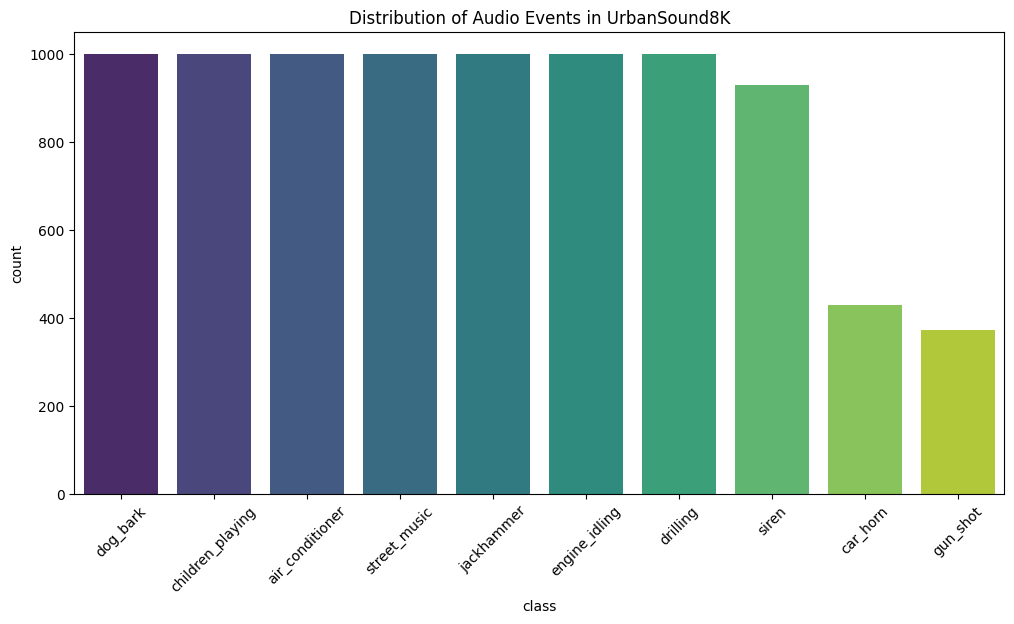

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load metadata
metadata = pd.read_csv('/kaggle/input/datasets/chrisfilo/urbansound8k/UrbanSound8K.csv')

# Check class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=metadata, x='class', order=metadata['class'].value_counts().index, palette='viridis')
plt.title("Distribution of Audio Events in UrbanSound8K")
plt.xticks(rotation=45)
plt.show()

# Display first few rows
print(metadata.head())

In [3]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.8 MB/s eta 0:00:00


Metadata loaded successfully from: /kaggle/input/datasets/chrisfilo/urbansound8k/UrbanSound8K.csv
Found 8732 total audio samples.
Analyzing audio properties (Sample Rates & Durations)...
Extracting features (MFCCs) for advanced analysis...
Detected 3 outliers based on MFCC_0 distribution.


/tmp/ipykernel_17/3129972.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_id', y='mfcc_0', data=feat_df, palette='Set3')


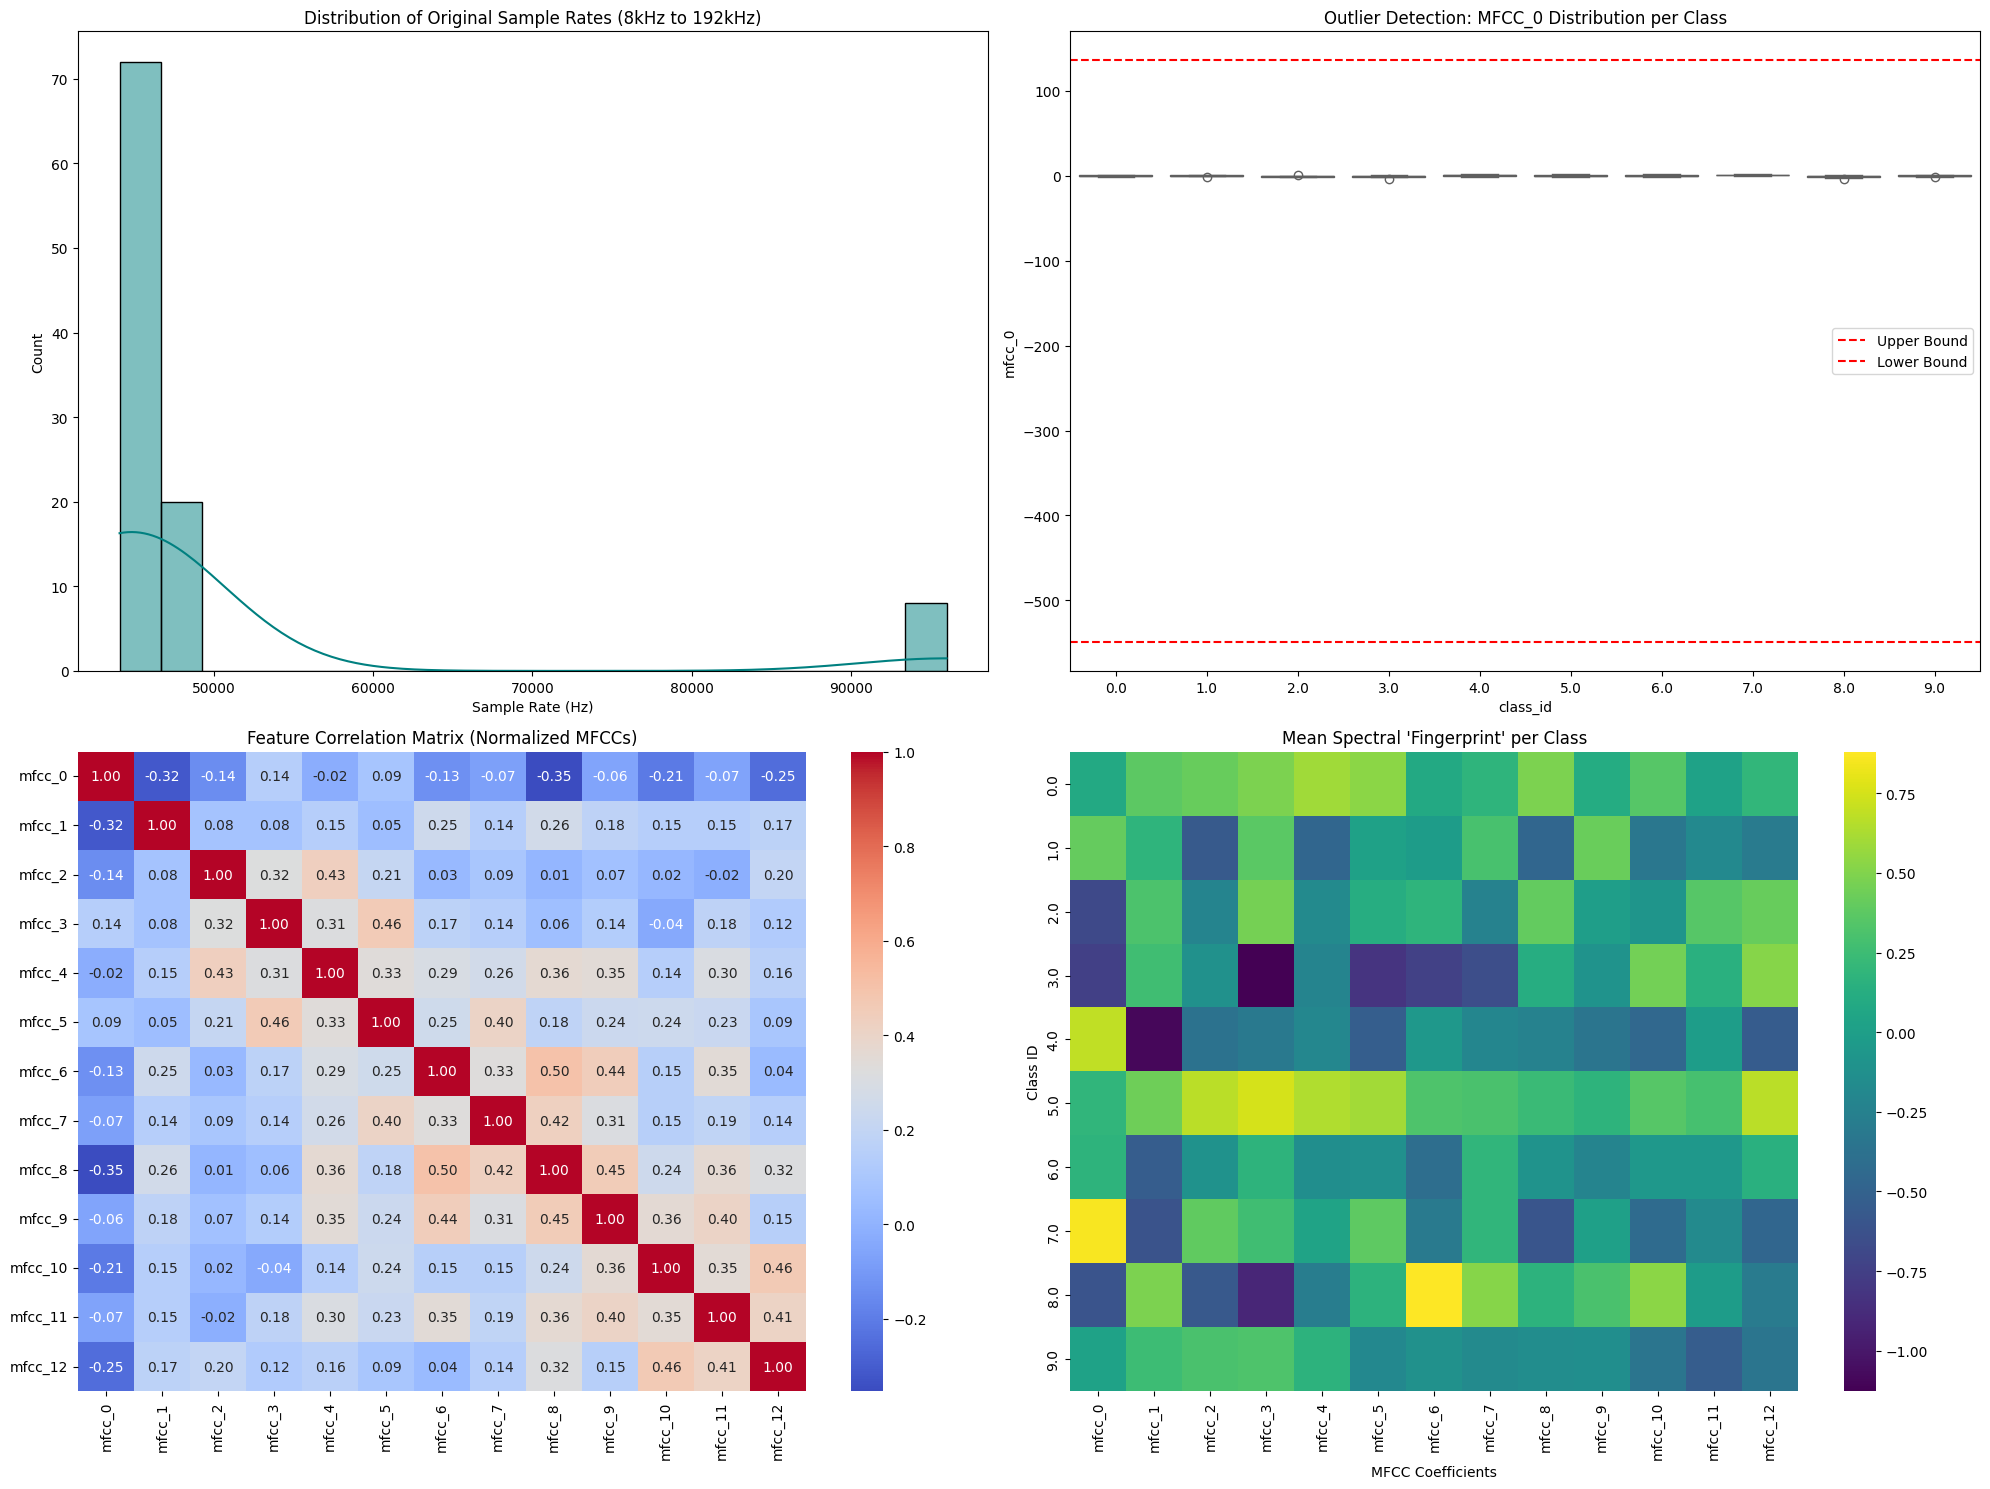

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# 1. Setup Corrected Paths for your Kaggle Dataset
# Using your explicitly provided path
BASE_PATH = '/kaggle/input/datasets/chrisfilo/urbansound8k'

# The metadata CSV is typically in the root of the dataset folder
METADATA_PATH = os.path.join(BASE_PATH, 'UrbanSound8K.csv')

# Audio files are often nested. This check ensures we find the 'audio' folder if it exists.
AUDIO_DIR = os.path.join(BASE_PATH, 'audio')
if not os.path.exists(AUDIO_DIR):
    AUDIO_DIR = BASE_PATH # Use root if 'audio' folder isn't present

# Load the metadata
try:
    metadata = pd.read_csv(METADATA_PATH)
    print(f"Metadata loaded successfully from: {METADATA_PATH}")
    print(f"Found {len(metadata)} total audio samples.")
except FileNotFoundError:
    print(f"ERROR: Could not find UrbanSound8K.csv at {METADATA_PATH}. Please check the folder structure.")

# 2. Demonstrate Varying Sample Rates & Durations
# This addresses the project requirement to analyze spectral characteristics [cite: 5, 13]
print("Analyzing audio properties (Sample Rates & Durations)...")
audio_props = []
for i, row in metadata.sample(100).iterrows():
    file_path = os.path.join(AUDIO_DIR, f"fold{row['fold']}", row['slice_file_name'])
    try:
        # sr=None ensures we get the original sample rate to show diversity
        y, sr_orig = librosa.load(file_path, sr=None)
        audio_props.append({'sample_rate': sr_orig, 'duration': len(y)/sr_orig, 'class': row['class']})
    except Exception as e:
        continue

prop_df = pd.DataFrame(audio_props)

# 3. Feature Extraction (MFCCs) for Outlier & Normalization Demo
# Standardizing to 22050Hz for consistency across the model pipeline
print("Extracting features (MFCCs) for advanced analysis...")
features = []
for i, row in metadata.sample(200).iterrows():
    file_path = os.path.join(AUDIO_DIR, f"fold{row['fold']}", row['slice_file_name'])
    try:
        # Loading with default resampler to avoid resampy dependency
        y, sr = librosa.load(file_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        features.append(np.append(mfcc_mean, row['classID']))
    except Exception as e:
        continue

feat_cols = [f'mfcc_{i}' for i in range(13)] + ['class_id']
feat_df = pd.DataFrame(features, columns=feat_cols)

# 4. Outlier Detection (IQR Method)
# Identifying anomalies in energy distribution (MFCC_0)
Q1 = feat_df['mfcc_0'].quantile(0.25)
Q3 = feat_df['mfcc_0'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = feat_df[(feat_df['mfcc_0'] < lower_bound) | (feat_df['mfcc_0'] > upper_bound)]
print(f"Detected {len(outliers)} outliers based on MFCC_0 distribution.")

# 5. Normalization (Standardization using Scikit-learn [cite: 15])
scaler = StandardScaler()
feat_df[feat_cols[:-1]] = scaler.fit_transform(feat_df[feat_cols[:-1]])

# 6. Advanced Visualizations for Submission Video [cite: 94]
plt.figure(figsize=(20, 15))

# Plot 1: Sample Rate Distribution (Shows dataset diversity)
plt.subplot(2, 2, 1)
sns.histplot(prop_df['sample_rate'], bins=20, kde=True, color='teal')
plt.title("Distribution of Original Sample Rates (8kHz to 192kHz)")
plt.xlabel("Sample Rate (Hz)")

# Plot 2: Outlier Detection Boxplot
plt.subplot(2, 2, 2)
sns.boxplot(x='class_id', y='mfcc_0', data=feat_df, palette='Set3')
plt.axhline(upper_bound, color='red', linestyle='--', label='Upper Bound')
plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.title("Outlier Detection: MFCC_0 Distribution per Class")
plt.legend()

# Plot 3: Feature Correlation Heatmap (Post-Normalization)
plt.subplot(2, 2, 3)
sns.heatmap(feat_df[feat_cols[:-1]].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix (Normalized MFCCs)")

# Plot 4: Mean Spectral Texture (Averaged MFCCs)
# Displays the unique "fingerprint" for events like sirens or barks 
plt.subplot(2, 2, 4)
mean_mfccs = feat_df.groupby('class_id')[feat_cols[:-1]].mean()
sns.heatmap(mean_mfccs, cmap='viridis')
plt.title("Mean Spectral 'Fingerprint' per Class")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Class ID")

plt.tight_layout()
plt.show()

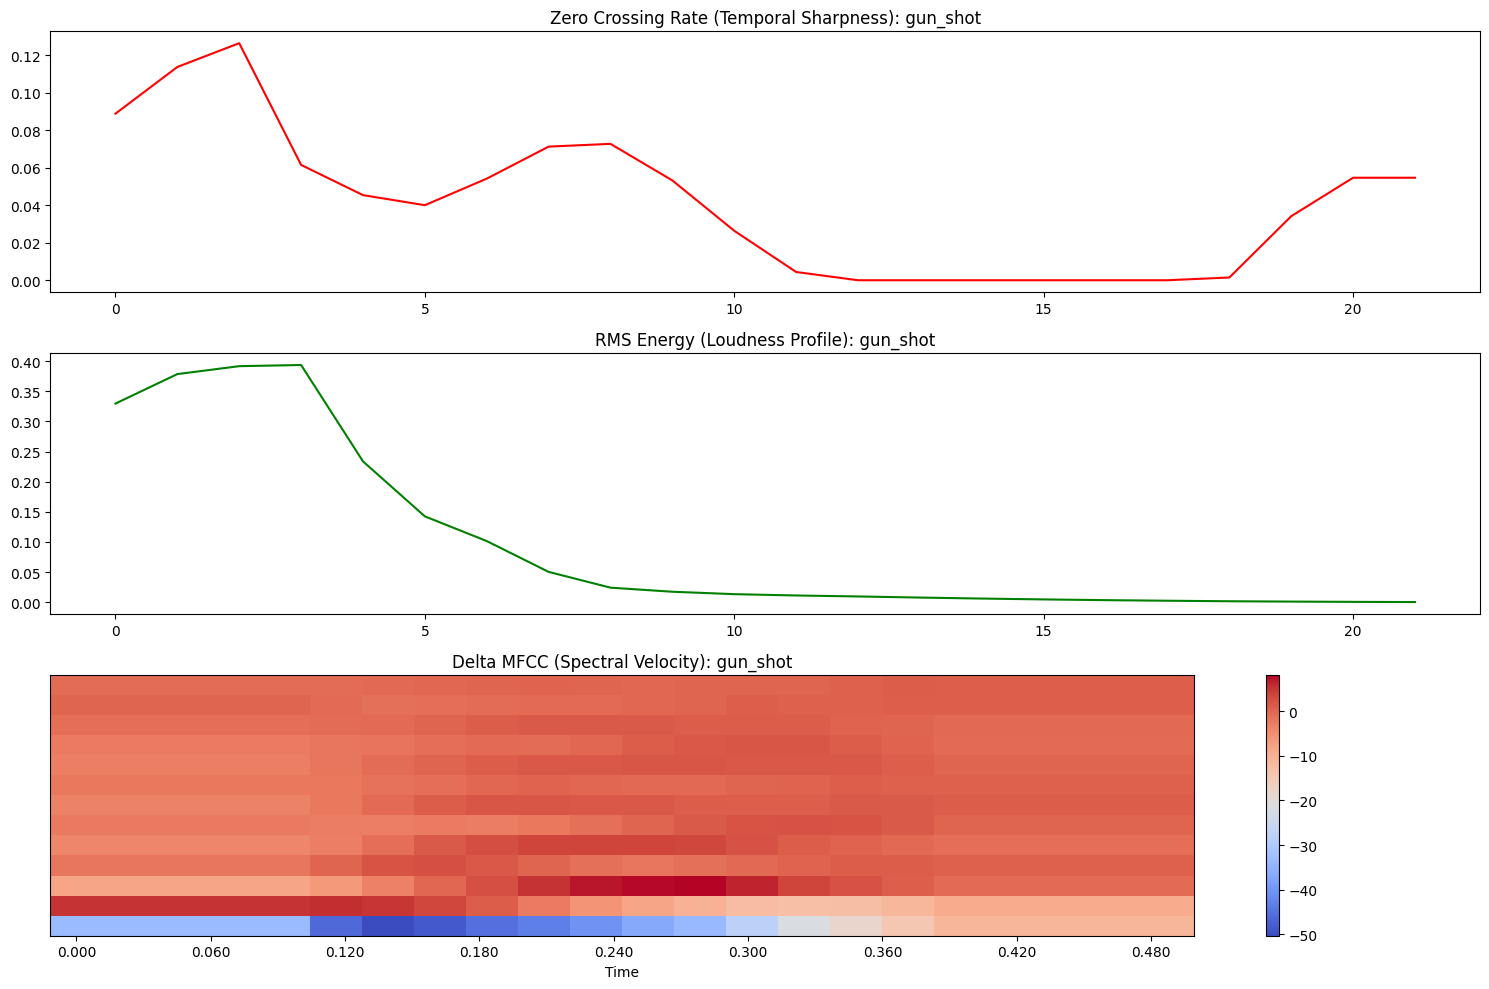

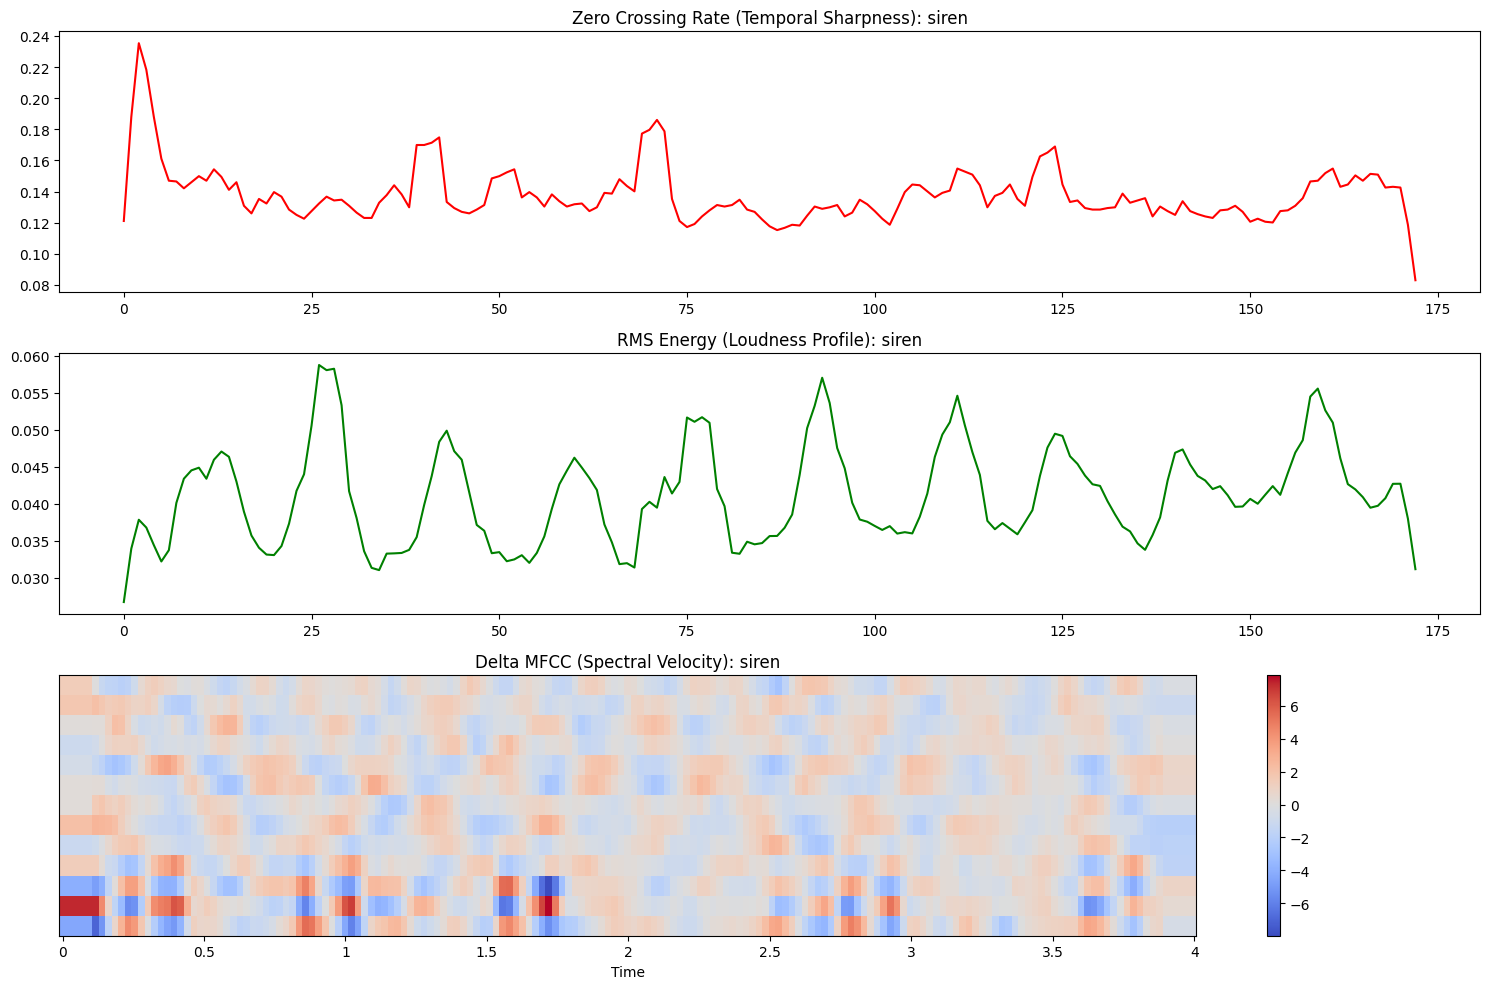

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the missing path variables
BASE_PATH = '/kaggle/input/datasets/chrisfilo/urbansound8k'
# Audio files are often in the root or an 'audio' subfolder in this dataset
AUDIO_DIR = os.path.join(BASE_PATH, 'audio') 
if not os.path.exists(AUDIO_DIR):
    AUDIO_DIR = BASE_PATH

def advanced_eda(class_name):
    # Load a sample
    sample = metadata[metadata['class'] == class_name].sample(1)
    
    # Construct path - using AUDIO_DIR now defined above
    path = os.path.join(AUDIO_DIR, f"fold{sample.fold.values[0]}", sample.slice_file_name.values[0])
    
    # Standardizing sample rate to avoid resampy dependency
    y, sr = librosa.load(path, sr=22050)

    plt.figure(figsize=(15, 10))

    # 1. Zero Crossing Rate: Identifies percussive vs. tonal sounds
    plt.subplot(3, 1, 1)
    zcr = librosa.feature.zero_crossing_rate(y)
    plt.plot(zcr[0], color='r')
    plt.title(f"Zero Crossing Rate (Temporal Sharpness): {class_name}")

    # 2. RMS Energy (Loudness): Detects signal strength and silence
    plt.subplot(3, 1, 2)
    rms = librosa.feature.rms(y=y)
    plt.plot(rms[0], color='g')
    plt.title(f"RMS Energy (Loudness Profile): {class_name}")

    # 3. Delta MFCCs (Spectral Change): Captures velocity of sound transitions
    plt.subplot(3, 1, 3)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc)
    librosa.display.specshow(delta_mfcc, x_axis='time', cmap='coolwarm')
    plt.colorbar()
    plt.title(f"Delta MFCC (Spectral Velocity): {class_name}")

    plt.tight_layout()
    plt.show()

# Run for security-critical classes
advanced_eda('gun_shot')
advanced_eda('siren')